# Main species and NH2 species 

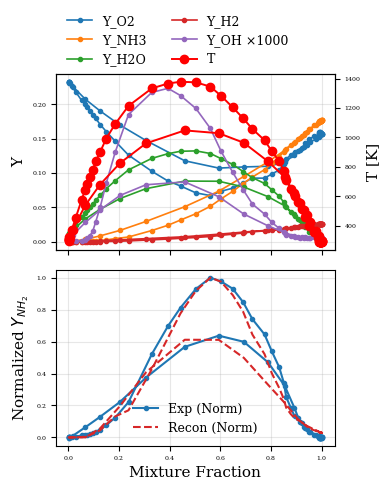

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Settings ----------
mechanism   = "KAUST_32s243r"
family      = "F"            # "D", "E", or "F"
norm_method = "max"          # "max" or "mean"
z_values    = [2]            # only z=4
sections    = [f"{family}_mass_z{z}" for z in z_values]

# Paths (mean data)
base_dir   = "cases/NH3_KAUST_DEF_1bar/exp_data/mean_csv_export"
# recon_root = f"cases/NH3_KAUST_DEF_1bar/exp_data/mean_Exp_QSSA/{mechanism}"
recon_root = f"cases/NH3_KAUST_DEF_1bar/exp_data/mean_Exp_QSSA_withOH/{mechanism}"

# ---------- Helpers ----------
def find_col(df, keys):
    for k in keys:
        if k in df.columns:
            return k
    raise KeyError(f"None of {keys} found in columns: {list(df.columns)}")

def z_from_section(sec):
    try:
        return sec.split("_z", 1)[1]
    except Exception:
        return sec

def normalize(series, method="max"):
    if len(series) == 0:
        return series
    denom = (series.mean() if method == "mean" else series.max())
    if denom == 0 or pd.isna(denom):
        denom = 1.0
    return series / denom

# ---------- Plot ----------
sec = sections[0]
base_file  = os.path.join(base_dir,  f"{sec}.csv")
recon_file = os.path.join(recon_root, sec, "predicted_X.csv")

if not (os.path.exists(base_file) and os.path.exists(recon_file)):
    raise FileNotFoundError(f"Missing files for {sec}:\n  {base_file}\n  {recon_file}")

df_base  = pd.read_csv(base_file)
df_recon = pd.read_csv(recon_file)

# Column names
col_phi_b = find_col(df_base,  ["mixture_fraction", "Z"])
col_phi_r = find_col(df_recon, ["mixture_fraction", "Z"])
col_nh2_b = find_col(df_base,  ["Y_NH2", "NH2"])
col_nh2_r = find_col(df_recon, ["Y_NH2", "NH2"])

# Top subplot variables
species_cols = {
    "Y_O2":  find_col(df_base, ["Y_O2","O2"]),
    # "Y_N2":  find_col(df_base, ["Y_N2","N2"]),
    "Y_NH3": find_col(df_base, ["Y_NH3","NH3"]),
    "Y_H2O": find_col(df_base, ["Y_H2O","H2O"]),
    "Y_H2":  find_col(df_base, ["Y_H2","H2"]),
    "Y_OH":  find_col(df_base, ["Y_OH","OH"]),   # mass fraction OH
}

# Multiply OH by 100 for better visibility
df_base[species_cols["Y_OH"]] = df_base[species_cols["Y_OH"]] * 100

# X_OH is optional (mole fraction)
col_X_OH = None
for cand in ["X_OH", "x_OH", "XO H", "X(OH)"]:
    if cand in df_base.columns:
        col_X_OH = cand
        break

# Temperature column (support a few variants)
col_T = None
for cand in ["T", "Temperature", "temp", "T_Raman", "T_ray"]:
    if cand in df_base.columns:
        col_T = cand
        break

# ---------- Figure ----------
plt.rcParams.update({
    "font.family": "serif",
    "axes.labelsize": 11,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
})
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 5.0), sharex=True)

# ---------- Subplot 1: main species + X_OH + T ----------
for label, col in species_cols.items():
    if label == "Y_OH":
        ax1.plot(df_base[col_phi_b], df_base[col], '-o', markersize=3,
                 linewidth=1.2, label=f"{label} ×1000")
    else:
        ax1.plot(df_base[col_phi_b], df_base[col], '-o', markersize=3,
                 linewidth=1.2, label=label)

if col_X_OH is not None:
    ax1.plot(df_base[col_phi_b], df_base[col_X_OH], '-o', markersize=3,
             linewidth=1.2, linestyle="--", label="X_OH")

if col_T is not None:
    ax1_t = ax1.twinx()
    ax1_t.plot(df_base[col_phi_b], df_base[col_T], '-o',
               color="red", linewidth=1.4, label="T")  # ← red temperature line
    ax1_t.set_ylabel("T [K]")
    # Combine legends
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax1_t.get_legend_handles_labels()
    ax1.legend(
    h1 + h2, l1 + l2,
    loc="upper left",                # base anchor position
    bbox_to_anchor=(0, 1.4),      # move legend outside to the right
    frameon=False,
    ncol=2
)
else:
    ax1.legend(loc="best", frameon=False, ncol=2)  # ← two columns here too

# ax1.set_title(f"{family}-flame, z={z_from_section(sec)} — Base: main species / X_OH / T vs Mixture Fraction")
ax1.set_ylabel("Y")
ax1.grid(True, alpha=0.3)

# ---------- Subplot 2: normalized Y_NH2 (base vs recon) ----------
nh2_base_norm  = normalize(df_base[col_nh2_b].copy(),  method=norm_method)
nh2_recon_norm = normalize(df_recon[col_nh2_r].copy(), method=norm_method)

ax2.plot(df_base[col_phi_b],  nh2_base_norm,  "o-", markersize=3,
         color="tab:blue",  label=f"Exp (Norm)")
ax2.plot(df_recon[col_phi_r], nh2_recon_norm, "--",
         linewidth=1.5, color="tab:red", label=f"Recon (Norm)")

# ax2.set_title("Normalized $Y_{NH_2}$ — Exp vs Recon")
ax2.set_xlabel("Mixture Fraction")
ax2.set_ylabel(r"Normalized $Y_{NH_2}$")
ax2.grid(True, alpha=0.3)
ax2.legend(loc="best", frameon=False)

plt.tight_layout()
plt.show()

# Reconstruction using the mean result

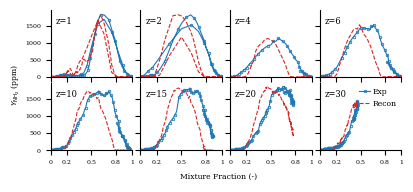

Saved: figs/NH2_recon/NH2_Recon_E_300pt_profile.png


In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# ===================== Settings =====================
mechanism   = "KAUST_32s243r"
family      = "E"          # "D", "E", or "F"
norm_method = "max"

z_values = [1, 2, 4, 6, 10, 15, 20, 30]
sections = [f"{family}_mass_z{z}" for z in z_values]

# Paths
base_dir   = "cases/NH3_KAUST_DEF_1bar/exp_data/mean_csv_export"
# recon_root = f"cases/NH3_KAUST_DEF_1bar/exp_data/mean_Exp_QSSA_withOH/{mechanism}"
recon_root = f"cases/NH3_KAUST_DEF_1bar/exp_data/mean_Exp_QSSA/{mechanism}"


# Figure size: width = 300 pt = 300/72 in
FIG_WIDTH_PT = 300
FIG_WIDTH_IN = FIG_WIDTH_PT / 72.0
ASPECT = 5.5 / 12.0
FIG_HEIGHT_IN = FIG_WIDTH_IN * ASPECT

# Font sizes tuned for single-column figure
FS_LABEL  = 5.5
FS_TITLE  = 5.5
FS_LEGEND = 5.5
FS_ZTEXT  = 6
FS_TICK   = 4.5
# ====================================================

def find_col(df, keys):
    for k in keys:
        if k in df.columns:
            return k
    raise KeyError(f"None of {keys} found in {list(df.columns)}")

def z_from_section(sec):
    try:
        return sec.split("_z", 1)[1]
    except Exception:
        return sec

def normalize(series, method="max"):
    if series.empty:
        return series
    denom = series.mean() if method == "mean" else series.max()
    return series / denom if denom else series

# ---------- Plot ----------
ncols, nrows = 4, 2
plt.rcParams.update({
    "font.family": "serif",
    "axes.labelsize": FS_LABEL,
    "axes.titlesize": FS_TITLE,
    "legend.fontsize": FS_LEGEND,
    "xtick.labelsize": FS_TICK,
    "ytick.labelsize": FS_TICK,
})

fig, axes = plt.subplots(nrows, ncols,
                         figsize=(FIG_WIDTH_IN, FIG_HEIGHT_IN),
                         sharex=True, sharey=True)
axes = axes.flatten()

global_ymax = 0.0
for i, sec in enumerate(sections):
    ax = axes[i]
    base_file  = os.path.join(base_dir,  f"{sec}.csv")
    recon_file = os.path.join(recon_root, sec, "predicted_X.csv")
    if not (os.path.exists(base_file) and os.path.exists(recon_file)):
        ax.set_axis_off()
        continue

    df_base, df_recon = pd.read_csv(base_file), pd.read_csv(recon_file)
    col_phi_b  = find_col(df_base,  ["mixture_fraction", "Z"])
    col_nh2_b  = find_col(df_base,  ["NH2", "Y_NH2"])
    col_phi_r  = find_col(df_recon, ["mixture_fraction", "Z"])
    col_nh2_r  = find_col(df_recon, ["NH2", "Y_NH2"])

    nh2_base_norm  = normalize(df_base[col_nh2_b], norm_method)
    nh2_recon_norm = normalize(df_recon[col_nh2_r], norm_method)
    recon_max_raw = df_recon[col_nh2_r].max() or 1.0

    # --- Convert to ppm (multiply by 1e6) ---
    nh2_base_scaled  = nh2_base_norm  * recon_max_raw * 1e6
    nh2_recon_scaled = nh2_recon_norm * recon_max_raw * 1e6

    global_ymax = max(global_ymax, nh2_base_scaled.max(), nh2_recon_scaled.max())

    # --- Plot curves with hollow markers for Exp ---
    ax.plot(df_base[col_phi_b], nh2_base_scaled, "o-",
            color="C0", markerfacecolor="none", markeredgecolor="C0",
            markeredgewidth=0.6, markersize=1.8, linewidth=0.8, markevery=2, label="Exp")

    # Recon curve (solid line, no markers)
    ax.plot(df_recon[col_phi_r], nh2_recon_scaled, "--",
            color="C3", linewidth=0.8, label="Recon")

    # z-label inside panel
    ax.text(0.06, 0.9, f"z={z_from_section(sec)}", transform=ax.transAxes,
            ha="left", va="top", fontsize=FS_ZTEXT)

    # Style cleanup
    ax.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Custom tick labels
    ax.set_xticks([0, 0.2, 0.5, 0.8, 1.0])
    ax.set_xticklabels(["0", "0.2", "0.5", "0.8", "1"])
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))  # integer ppm

# Hide unused subplots
for j in range(len(sections), len(axes)):
    axes[j].set_visible(False)

# Consistent limits
for ax in axes:
    if ax.get_visible():
        ax.set_xlim(0.0, 1.0)
        ax.set_ylim(0.0, global_ymax * 1.05)

# Axis labels
fig.text(0.5, 0, "Mixture Fraction (-)", ha="center", fontsize=FS_TITLE)
fig.text(0, 0.5, r"$Y_{\mathrm{NH_2}}$ (ppm)", va="center",
         rotation="vertical", fontsize=FS_TITLE)

# Legend inside 4th subplot
handles, labels = axes[7].get_legend_handles_labels()
legend_ax = axes[7]
legend_ax.legend(handles, labels, loc="upper right",
                 frameon=False, ncol=1, borderaxespad=0.2,
                 handlelength=1.5, handletextpad=0.3)

# Ultra-tight layout for 1-column figure
plt.tight_layout(rect=[0, 0, 0.98, 0.97], w_pad=0.1, h_pad=0.1)

# Save outputs
out_png = f"figs/NH2_recon/NH2_Recon_{family}_300pt_profile.png"
plt.savefig(out_png, bbox_inches="tight", dpi=300)
plt.show()
print(f"Saved: {out_png}")


# Plot the countour

[Saved & cropped] figs/NH2_recon/NH2_Recon_F_Contour_Exp_Recon.png


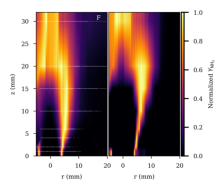

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from matplotlib.gridspec import GridSpec

# ---------- Settings ----------
mechanism   = "KAUST_32s243r"
family      = "F"
norm_method = "max"
z_values    = [1, 2, 4, 6, 10, 15, 20, 30]
sections    = [f"{family}_mass_z{z}" for z in z_values]

r_lim = (-5.0, 20.0)
z_lim = (0.0, 32.0)
Nr, Nz = 400, 300
sigma_smooth = 1.0

base_dir   = "cases/NH3_KAUST_DEF_1bar/exp_data/mean_csv_export"
# recon_root = f"cases/NH3_KAUST_DEF_1bar/exp_data/mean_Exp_QSSA_withOH/{mechanism}"
recon_root = f"cases/NH3_KAUST_DEF_1bar/exp_data/mean_Exp_QSSA/{mechanism}"

out_dir    = "figs/NH2_recon"
os.makedirs(out_dir, exist_ok=True)

# ---------- Figure & fonts ----------
FIG_WIDTH_PT = 300
FIG_WIDTH_IN = FIG_WIDTH_PT / 72.0
ASPECT = 5.5 / 12.0
FIG_HEIGHT_IN = FIG_WIDTH_IN * ASPECT

FS_LABEL  = 4.5
FS_TITLE  = 4.5
FS_LEGEND = 4.5
FS_TICK   = 4.5

plt.rcParams.update({
    "font.family": "serif",
    "axes.labelsize": FS_LABEL,
    "axes.titlesize": FS_TITLE,
    "legend.fontsize": FS_LEGEND,
    "xtick.labelsize": FS_TICK,
    "ytick.labelsize": FS_TICK,
})

# ---------- Helpers ----------
def find_col(df, keys):
    for k in keys:
        if k in df.columns:
            return k
    raise KeyError(f"None of {keys} found in {list(df.columns)}")

def normalize(series, method="max"):
    if series.empty:
        return series
    denom = series.mean() if method == "mean" else series.max()
    denom = denom if (denom not in (0, None) and np.isfinite(denom)) else 1.0
    return series / denom

def z_from_section(sec):
    try:
        return float(sec.split("_z", 1)[1])
    except Exception:
        return np.nan

def load_and_normalize_profile(csv_path, method):
    df = pd.read_csv(csv_path)
    col_r = find_col(df, ["r_mm", "r", "radius_mm"])
    col_y = find_col(df, ["Y_NH2", "NH2"])
    r = df[col_r].to_numpy(float)
    y = normalize(df[col_y].copy(), method=method).to_numpy(float)
    m = np.isfinite(r) & np.isfinite(y)
    r, y = r[m], y[m]
    if r.size == 0:
        return None, None
    order = np.argsort(r)
    return r[order], y[order]

# ---------- Gather points ----------
pts_exp, val_exp, pts_rec, val_rec = [], [], [], []
r_points_exp, z_points_exp = [], []

for sec in sections:
    base_file  = os.path.join(base_dir,  f"{sec}.csv")
    recon_file = os.path.join(recon_root, sec, "predicted_X.csv")
    if not (os.path.exists(base_file) and os.path.exists(recon_file)):
        continue
    z0 = z_from_section(sec)
    rb, yb = load_and_normalize_profile(base_file,  norm_method)
    rr, yr = load_and_normalize_profile(recon_file, norm_method)
    if rb is None or rr is None:
        continue
    pts_exp.append(np.column_stack([rb, np.full_like(rb, z0)]))
    val_exp.append(yb)
    pts_rec.append(np.column_stack([rr, np.full_like(rr, z0)]))
    val_rec.append(yr)
    r_points_exp.extend(rb)
    z_points_exp.extend(np.full_like(rb, z0))

if not pts_exp or not pts_rec:
    raise RuntimeError("No valid sections found.")

pts_exp = np.vstack(pts_exp); val_exp = np.concatenate(val_exp)
pts_rec = np.vstack(pts_rec); val_rec = np.concatenate(val_rec)
r_points_exp = np.asarray(r_points_exp, float)
z_points_exp = np.asarray(z_points_exp, float)

# ---------- Grid ----------
r_vec = np.linspace(r_lim[0], r_lim[1], Nr)
z_vec = np.linspace(z_lim[0], z_lim[1], Nz)
R, Z  = np.meshgrid(r_vec, z_vec)

grid_exp = griddata(pts_exp, val_exp, (R, Z), method="linear")
grid_rec = griddata(pts_rec, val_rec, (R, Z), method="linear")

nn_exp = griddata(pts_exp, val_exp, (R, Z), method="nearest")
nn_rec = griddata(pts_rec, val_rec, (R, Z), method="nearest")

mask_exp = ~np.isfinite(grid_exp)
mask_rec = ~np.isfinite(grid_rec)
grid_exp[mask_exp] = nn_exp[mask_exp]
grid_rec[mask_rec] = nn_rec[mask_rec]

if sigma_smooth > 0:
    grid_exp = gaussian_filter(grid_exp, sigma=sigma_smooth, mode="nearest")
    grid_rec = gaussian_filter(grid_rec, sigma=sigma_smooth, mode="nearest")

grid_exp = np.clip(grid_exp, 0.0, 1.0)
grid_rec = np.clip(grid_rec, 0.0, 1.0)

# ---------- Plot ----------
fig = plt.figure(figsize=(FIG_WIDTH_IN * 0.4, FIG_HEIGHT_IN))
gs = GridSpec(1, 3, width_ratios=[1, 1, 0.04], wspace=0.03)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
cax = fig.add_subplot(gs[0, 2])

# ---- Reduce axis frame and tick width ----
for ax in (ax1, ax2):
    # Thinner spines (border lines)
    for spine in ax.spines.values():
        spine.set_linewidth(0.4)  # default ~1.0
    # Thinner tick marks
    ax.tick_params(width=0.4, length=2)  # shorter and lighter ticks
    
vmin, vmax = 0.0, 1.0
cmap = "inferno"
ax1.pcolormesh(R, Z, grid_exp, shading="auto", vmin=vmin, vmax=vmax, cmap=cmap)
im2 = ax2.pcolormesh(R, Z, grid_rec, shading="auto", vmin=vmin, vmax=vmax, cmap=cmap)

# Shared colorbar
cb = fig.colorbar(im2, cax=cax)
cb.set_label(r"Normalized $Y_{\mathrm{NH_2}}$", fontsize=FS_LABEL)
cb.ax.tick_params(labelsize=FS_TICK)

# Overlay measurements
ax1.scatter(r_points_exp, z_points_exp, s=0.01, c="white", linewidths=0.25, alpha=0.8)
ax1.text(0.85, 0.98, f"{family}", transform=ax1.transAxes,
         color="white", fontsize=FS_LEGEND, va="top", ha="left")

# Titles and labels
# ax1.set_title("Experiments", fontsize=FS_TITLE)
# ax2.set_title("Reconstruction", fontsize=FS_TITLE)
for ax in (ax1, ax2):
    ax.set_xlim(r_lim)
    ax.set_xlabel("r (mm)", fontsize=FS_LABEL)
ax1.set_ylim(z_lim)
ax1.set_ylabel("z (mm)", fontsize=FS_LABEL)

# Remove redundant y-axis ticks on right subplot
ax2.tick_params(left=False, labelleft=False)

# Tight margins
fig.subplots_adjust(left=0.065, right=0.995, bottom=0.13, top=0.92, wspace=0.02)

out_png = os.path.join(out_dir, f"NH2_Recon_{family}_Contour_Exp_Recon.png")
fig.savefig(out_png, dpi=600, bbox_inches="tight", pad_inches=0.002)
plt.close(fig)

# ---------- Auto-crop (Pillow) ----------
try:
    from PIL import Image, ImageOps, ImageChops
    img = Image.open(out_png).convert("RGBA")
    bg = Image.new("RGBA", img.size, (255, 255, 255, 0))
    diff = ImageChops.difference(img, bg)
    bbox = diff.getbbox()
    if bbox:
        img = img.crop(bbox)
    border_px = 0  # set >0 if you want a small frame after crop
    if border_px > 0:
        img = ImageOps.expand(img, border=border_px, fill=(255, 255, 255, 0))
    img.save(out_png)
    print(f"[Saved & cropped] {out_png}")
except Exception as e:
    print(f"[Saved (no Pillow auto-crop)] {out_png}  -- Install pillow to enable auto-crop. Error: {e}")

# ---------- Show cropped figure ----------
import matplotlib.image as mpimg
img_cropped = mpimg.imread(out_png)
plt.figure(figsize=(4, 2))
plt.imshow(img_cropped)
plt.axis("off")
plt.tight_layout()
plt.show()

# Combine figures 

In [120]:
#!/usr/bin/env python3
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ---------- Config ----------
base_dir = Path("figs/NH2_recon")
out_pdf  = base_dir / "NH2_Recon_Combined_3x2_A4.pdf"

# Desired layout (3 rows × 2 columns)
panel_paths = [
    [base_dir / "NH2_Recon_D_Contour_Exp_Recon.png", base_dir / "NH2_Recon_D_300pt_profile.pdf"],
    [base_dir / "NH2_Recon_E_Contour_Exp_Recon.png", base_dir / "NH2_Recon_E_300pt_profile.pdf"],
    [base_dir / "NH2_Recon_F_Contour_Exp_Recon.png", base_dir / "NH2_Recon_F_300pt_profile.pdf"],
]

# ---------- Helpers ----------
def load_image_any(path, dpi=300):
    """Load an image (png/jpg/pdf) into a NumPy RGBA array."""
    path = Path(path)
    ext = path.suffix.lower()
    if ext in {".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp"}:
        from PIL import Image
        return np.asarray(Image.open(path).convert("RGBA"))
    if ext == ".pdf":
        # Rasterize first page
        try:
            import fitz  # PyMuPDF
            doc = fitz.open(path)
            page = doc.load_page(0)
            zoom = dpi / 72.0
            mat = fitz.Matrix(zoom, zoom)
            pix = page.get_pixmap(matrix=mat, alpha=True)
            arr = np.frombuffer(pix.samples, dtype=np.uint8)
            img = arr.reshape((pix.height, pix.width, pix.n))
            doc.close()
            if img.shape[2] == 3:  # add alpha if missing
                alpha = 255 * np.ones((img.shape[0], img.shape[1], 1), dtype=np.uint8)
                img = np.concatenate([img, alpha], axis=2)
            return img
        except Exception:
            from pdf2image import convert_from_path
            pil = convert_from_path(str(path), dpi=dpi, first_page=1, last_page=1)[0]
            return np.asarray(pil.convert("RGBA"))
    raise ValueError(f"Unsupported file type: {path}")

def check_files_exist(paths_2d):
    missing = [str(p) for row in paths_2d for p in row if not Path(p).exists()]
    if missing:
        print("Missing files:\n" + "\n".join(missing), file=sys.stderr)
        sys.exit(1)

# ---------- Main ----------
def main():
    check_files_exist(panel_paths)
    imgs = [[load_image_any(p) for p in row] for row in panel_paths]

    # Figure width fixed to 320 pt (single-column A4), compute height from native row aspect
    width_in = 320 / 72.0  # inches
    # Use first row to get native widths/heights (assumes same height per row, which you ensured)
    h0, wL, _ = imgs[0][0].shape
    h1, wR, _ = imgs[0][1].shape
    # keep their native aspect (same height): row_aspect = height / (wL + wR)
    row_aspect = float(h0) / float(wL + wR)
    rows = 3
    # small physical gaps between rows (inches); columns get minimal gap via wspace
    hgap_in = 0.03
    height_in = rows * (width_in * row_aspect) + (rows - 1) * hgap_in

    # Build with tight spacing, preserve native column width ratio
    fig, axes = plt.subplots(
        nrows=3, ncols=2,
        figsize=(width_in, height_in),
        gridspec_kw={
            "width_ratios": [wL, wR],
            "wspace": 0.02,  # tiny column gap
            "hspace": hgap_in / (height_in / rows)  # convert physical gap to fraction
        }
    )

    for i in range(3):
        for j in range(2):
            ax = axes[i, j]
            ax.axis("off")
            # aspect='auto' ensures no forced square pixels; native proportions preserved by width_ratios/figsize
            ax.imshow(imgs[i][j], interpolation="none", aspect="auto")

    # Trim outer margins closely
    plt.subplots_adjust(left=0.005, right=0.995, top=0.995, bottom=0.005)

    out_pdf.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_pdf, dpi=350)
    plt.close(fig)
    print(f"Saved combined figure to:\n  {out_pdf}")

if __name__ == "__main__":
    main()

Saved combined figure to:
  figs/NH2_recon/NH2_Recon_Combined_3x2_A4.pdf


# Plot the PDF over Mixture Fraction

[Saved] figs/NH2_recon/scatter/NH2_scatter_D_z6_KAUST_32s243r_3panel_cby-Y_NH3.png


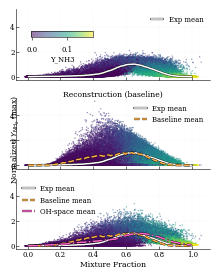

In [128]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib
from matplotlib import patheffects as pe

# ---------- Settings ----------
mechanism   = "KAUST_32s243r"
family      = "D"
norm_method = "max"
z_values    = [6]

sections = [f"{family}_mass_z{z}" for z in z_values]

# Paths
scatter_base_dir            = "cases/NH3_KAUST_DEF_1bar/exp_data/single_point_csv_export"
scatter_recon_baseline_root = f"cases/NH3_KAUST_DEF_1bar/exp_data/space_single_shot_Exp_QSSA/{mechanism}"
scatter_recon_oh_root       = f"cases/NH3_KAUST_DEF_1bar/exp_data/space_single_shot_Exp_QSSA_OH/{mechanism}"

out_dir = "figs/NH2_recon/scatter"
os.makedirs(out_dir, exist_ok=True)

# ---------- Appearance ----------
color_key   = "Y_NH3"
cmap_name   = "viridis"
color_range = None

# figure width 150 pt (≈2.083 in)
TARGET_WIDTH_PT = 150
PT2IN = 1 / 72.0
w_in = TARGET_WIDTH_PT * PT2IN
base_w, base_h = 6.4, 8.2
h_in = w_in * (base_h / base_w)

plt.rcParams.update({
    "font.family": "serif",
    "font.size": 5.5,
    "axes.labelsize": 5.5,
    "axes.titlesize": 5.5,
    "legend.fontsize": 5,
    "xtick.labelsize": 5,
    "ytick.labelsize": 5,
    "axes.linewidth": 0.4,
    "grid.alpha": 0.15,
})

# ---------- Helpers ----------
def find_col(df, keys):
    for k in keys:
        if k in df.columns:
            return k
    raise KeyError(f"None of {keys} found in columns: {list(df.columns)}")

def try_find_col(df, keys):
    for k in keys:
        if k in df.columns:
            return k
    return None

def compute_mean_profile(df, xcol, ycol, bins=200):
    x = np.clip(df[xcol].to_numpy(), 0.0, 1.0)
    y = df[ycol].to_numpy()
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    if x.size == 0:
        return np.array([]), np.array([])
    edges   = np.linspace(0.0, 1.0, bins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])
    inds    = np.digitize(x, edges) - 1
    valid   = (inds >= 0) & (inds < bins)
    inds, y = inds[valid], y[valid]
    y_mean  = np.full(bins, np.nan)
    if inds.size:
        sums   = np.bincount(inds, weights=y, minlength=bins)
        counts = np.bincount(inds, minlength=bins)
        with np.errstate(invalid="ignore", divide="ignore"):
            y_mean = sums / counts
        y_mean[counts == 0] = np.nan
    good = ~np.isnan(y_mean)
    return centers[good], y_mean[good]

def normalize_by(arr, denom):
    denom = denom if denom not in (None, 0, np.nan) else 1.0
    return np.asarray(arr) / denom

def get_color_column(df, desired_key):
    mapping = {
        "T":      ["T", "Temperature", "Temp", "temp", "Temp_K"],
        "T'":     ["T'", "T_prime", "Tprime", "T_rms", "Trms", "T_fluct", "T_std"],
        "Y_OH":   ["Y_OH", "OH", "Y(OH)", "massfrac_OH", "OH_massfrac"],
        "OH":     ["Y_OH", "OH", "Y(OH)", "massfrac_OH", "OH_massfrac"],
        "Y_NH3":  ["Y_NH3", "NH3", "Y(NH3)", "massfrac_NH3", "NH3_massfrac"],
    }
    col = try_find_col(df, mapping.get(desired_key, [desired_key]))
    return (col, desired_key) if col is not None else (None, desired_key)

def style_axes(ax):
    for s in ax.spines.values():
        s.set_linewidth(0.4)
    ax.tick_params(width=0.4, length=2.0, direction="in", pad=1)
    ax.grid(alpha=0.12, linewidth=0.3)

# Bright line styles (white/orange/magenta with black halo)
LINE_PEFX = [pe.Stroke(linewidth=1.6, foreground="black"), pe.Normal()]
STYLE_EXP = dict(color="white",    lw=1.1, solid_capstyle="round", zorder=6, path_effects=LINE_PEFX)
STYLE_BASE= dict(color="#ffb347", lw=1.1, ls="--", solid_capstyle="round", zorder=6, path_effects=LINE_PEFX)
STYLE_OH  = dict(color="#ff66cc", lw=1.1, ls="-.", solid_capstyle="round", zorder=6, path_effects=LINE_PEFX)

# ---------- Plot ----------
for sec in sections:
    z_str = sec.split("_z")[1]
    base_file       = os.path.join(scatter_base_dir,            f"{sec}.csv")
    recon_base_file = os.path.join(scatter_recon_baseline_root, sec, "predicted_X.csv")
    recon_oh_file   = os.path.join(scatter_recon_oh_root,       sec, "predicted_X.csv")

    if not (os.path.exists(base_file) and os.path.exists(recon_base_file) and os.path.exists(recon_oh_file)):
        print(f"[Skip] Missing files for {sec}")
        continue

    df_exp    = pd.read_csv(base_file)
    df_r_base = pd.read_csv(recon_base_file)
    df_r_oh   = pd.read_csv(recon_oh_file)

    col_phi_exp = find_col(df_exp, ["mixture_fraction", "Z"])
    col_y_exp   = find_col(df_exp, ["NH2", "Y_NH2"])
    col_phi_rb  = find_col(df_r_base, ["mixture_fraction", "Z"])
    col_y_rb    = find_col(df_r_base, ["NH2", "Y_NH2"])
    col_phi_roh = find_col(df_r_oh, ["mixture_fraction", "Z"])
    col_y_roh   = find_col(df_r_oh, ["NH2", "Y_NH2"])

    x_exp, y_exp = df_exp[col_phi_exp], df_exp[col_y_exp]
    x_rb, y_rb   = df_r_base[col_phi_rb], df_r_base[col_y_rb]
    x_roh, y_roh = df_r_oh[col_phi_roh], df_r_oh[col_y_roh]

    xb,  yb  = compute_mean_profile(df_exp,    col_phi_exp, col_y_exp, 100)
    xrb, yrb = compute_mean_profile(df_r_base, col_phi_rb,  col_y_rb,  100)
    xro, yro = compute_mean_profile(df_r_oh,   col_phi_roh, col_y_roh, 100)

    denom_b  = np.nanmax(yb)  if yb.size else 1
    denom_rb = np.nanmax(yrb) if yrb.size else 1
    denom_ro = np.nanmax(yro) if yro.size else 1

    y_exp_n = normalize_by(y_exp, denom_b)
    y_rb_n  = normalize_by(y_rb,  denom_rb)
    y_roh_n = normalize_by(y_roh, denom_ro)
    yb_n    = normalize_by(yb,    denom_b)
    yrb_n   = normalize_by(yrb,   denom_rb)
    yro_n   = normalize_by(yro,   denom_ro)

    ymax = 1.05 * np.nanmax([np.nanmax(a) for a in [y_exp_n, y_rb_n, y_roh_n, yb_n, yrb_n, yro_n] if np.size(a)])

    ccol_exp, c_label = get_color_column(df_exp, color_key)
    c_exp = df_exp[ccol_exp].to_numpy() if ccol_exp else None

    vals = c_exp[np.isfinite(c_exp)]
    shared_vmin, shared_vmax = np.nanpercentile(vals, 1), np.nanpercentile(vals, 99)
    norm = Normalize(vmin=shared_vmin, vmax=shared_vmax)
    cmap = matplotlib.colormaps.get_cmap(cmap_name)

    fig, (ax1, ax2, ax3) = plt.subplots(
        3, 1, figsize=(w_in, h_in), sharex=True, sharey=True, constrained_layout=True
    )

    # Panel 1
    sc1 = ax1.scatter(x_exp, y_exp_n, s=1, c=c_exp, cmap=cmap, norm=norm,
                      alpha=0.55, lw=0, rasterized=True)
    if yb_n.size:
        ax1.plot(xb, yb_n, label="Exp mean", **STYLE_EXP)
    ax1.legend(frameon=False, loc="best", handlelength=1.8)
    style_axes(ax1)

    # Panel 2
    sc2 = ax2.scatter(x_rb, y_rb_n, s=1, c=df_r_base["Y_NH3"], cmap=cmap, norm=norm,
                      alpha=0.55, lw=0, rasterized=True)
    ax2.plot(xb, yb_n, label="Exp mean", **STYLE_EXP)
    ax2.plot(xrb, yrb_n, label="Baseline mean", **STYLE_BASE)
    ax2.set_title("Reconstruction (baseline)", pad=1)
    ax2.legend(frameon=False, loc="best", handlelength=1.8)
    style_axes(ax2)

    # Panel 3
    sc3 = ax3.scatter(x_roh, y_roh_n, s=1, c=df_r_oh["Y_NH3"], cmap=cmap, norm=norm,
                      alpha=0.55, lw=0, rasterized=True)
    ax3.plot(xb, yb_n, label="Exp mean", **STYLE_EXP)
    ax3.plot(xrb, yrb_n, label="Baseline mean", **STYLE_BASE)
    ax3.plot(xro, yro_n, label="OH-space mean", **STYLE_OH)
    ax3.set_xlabel("Mixture Fraction", labelpad=1)
    ax3.legend(frameon=False, loc="best", handlelength=1.8)
    style_axes(ax3)

    fig.text(0.02, 0.5, r"Normalized $Y_{\mathrm{NH_2}}$ (max)",
             va="center", rotation="vertical", fontsize=5.5)

    # ---- Horizontal colorbar in top-left of first subplot ----
    cbar_ax = fig.add_axes([0.12, 0.88, 0.3, 0.025])  # [x0, y0, width, height]
    cbar = fig.colorbar(sc1, cax=cbar_ax, orientation="horizontal")
    cbar.set_label(c_label, fontsize=5, labelpad=1)
    cbar.ax.tick_params(labelsize=5, width=0.4, length=2)
    cbar.outline.set_linewidth(0.4)

    # ---- Save figure as PNG ----
    out_path = os.path.join(
        out_dir,
        f"NH2_scatter_{family}_z{z_str}_{mechanism}_3panel_cby-{c_label.replace(' ','_')}.png"
    )
    fig.savefig(out_path, dpi=600, bbox_inches="tight", pad_inches=0.02, transparent=False)
    print(f"[Saved] {out_path}")
    plt.show()
    plt.close(fig)

# What about perturbations?

In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib

# ---------- Settings ----------
mechanism   = "KAUST_32s243r"
family      = "D"
norm_method = "max"  # "max" or "mean"
z_values    = [1, 2, 4, 6, 10, 15, 20, 30]
sections    = [f"{family}_mass_z{z}" for z in z_values]

# Paths
scatter_base_dir   = "cases/NH3_KAUST_DEF_1bar/exp_data/single_point_csv_export"
# scatter_recon_root = f"cases/NH3_KAUST_DEF_1bar/exp_data/space_single_shot_Exp_QSSA/{mechanism}"
scatter_recon_root = f"cases/NH3_KAUST_DEF_1bar/exp_data/space_single_shot_Exp_QSSA_OH/{mechanism}"

out_dir = "figs/NH2_recon/scatter"
os.makedirs(out_dir, exist_ok=True)

# ---------- Coloring config ----------
# Choose one of:
#   Raw fields: "T", "T'", "Y_OH", "Y_NH3", "Y_H2O", ...
#   Perturbations: "T_perturb", "Y_OH_perturb", "Y_NH3_perturb", "Y_H2O_perturb"
color_key      = "Y_NH3_perturb"
cmap_name      = "viridis"
color_range    = None         # (vmin, vmax) or None -> auto robust (1–99%)
perturb_bins   = 100          # mixture-fraction bins for the perturbation average
perturb_abs    = True         # True: |f - <f>_bin|; False: signed (f - <f>_bin)

# ---------- Helpers ----------
def find_col(df, keys):
    for k in keys:
        if k in df.columns:
            return k
    raise KeyError(f"None of {keys} found in columns: {list(df.columns)}")

def try_find_col(df, keys):
    for k in keys:
        if k in df.columns:
            return k
    return None

def compute_mean_profile(df, xcol, ycol, bins=200):
    x = np.clip(df[xcol].to_numpy(), 0.0, 1.0)
    y = df[ycol].to_numpy()
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    if x.size == 0:
        return np.array([]), np.array([])
    edges = np.linspace(0.0, 1.0, bins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])
    inds = np.digitize(x, edges) - 1
    in_range = (inds >= 0) & (inds < bins)
    inds, y = inds[in_range], y[in_range]
    y_mean = np.full(bins, np.nan)
    if inds.size:
        sums   = np.bincount(inds, weights=y, minlength=bins)
        counts = np.bincount(inds, minlength=bins)
        with np.errstate(invalid="ignore", divide="ignore"):
            y_mean = sums / counts
        y_mean[counts == 0] = np.nan
    good = ~np.isnan(y_mean)
    return centers[good], y_mean[good]

def normalize_by(arr, denom):
    denom = denom if denom not in (None, 0, np.nan) else 1.0
    return np.asarray(arr) / denom

def get_raw_field_column(df, desired_key):
    """
    Map a desired logical key to likely column names in df for RAW fields.
    Returns (colname_found, label_for_colorbar).
    """
    mapping = {
        "T":      ["T", "Temperature", "Temp", "temp", "Temp_K"],
        "T'":     ["T'", "T_prime", "Tprime", "T_rms", "Trms", "T_fluct", "T_std"],
        "Y_OH":   ["Y_OH", "OH", "Y(OH)", "massfrac_OH", "OH_massfrac"],
        "OH":     ["Y_OH", "OH", "Y(OH)", "massfrac_OH", "OH_massfrac"],
        "Y_NH3":  ["Y_NH3", "NH3", "Y(NH3)", "massfrac_NH3", "NH3_massfrac"],
        "Y_H2O":  ["Y_H2O", "H2O", "Y(H2O)", "massfrac_H2O", "H2O_massfrac"],
    }
    candidates = mapping.get(desired_key, [desired_key])
    col = try_find_col(df, candidates)
    if col is not None:
        return col, desired_key
    return None, desired_key

def parse_color_mode(color_key):
    """
    Return a tuple:
      ('perturb', base_key)  if color_key endswith '_perturb'
      ('raw', color_key)     otherwise
    base_key is one of "T", "Y_OH", "Y_NH3", "Y_H2O", ...
    """
    if color_key.endswith("_perturb"):
        return "perturb", color_key[:-9]  # strip '_perturb'
    return "raw", color_key

def compute_binwise_perturbation(df, xcol, val_col, bins=100, absolute=True):
    """
    Perturbation vs. bin-wise average in mixture fraction.
    """
    if val_col is None:
        return None
    x = np.clip(df[xcol].to_numpy(), 0.0, 1.0)
    v = df[val_col].to_numpy()

    edges = np.linspace(0.0, 1.0, bins + 1)
    inds  = np.digitize(x, edges) - 1  # 0..bins-1

    mask = np.isfinite(x) & np.isfinite(v) & (inds >= 0) & (inds < bins)
    inds_valid = inds[mask]
    v_valid    = v[mask]

    means = np.full(bins, np.nan)
    if inds_valid.size:
        sums   = np.bincount(inds_valid, weights=v_valid, minlength=bins)
        counts = np.bincount(inds_valid, minlength=bins)
        with np.errstate(invalid="ignore", divide="ignore"):
            means = sums / counts
        means[counts == 0] = np.nan

    bin_means_for_points = np.full_like(v, np.nan, dtype=float)
    valid_pts = (inds >= 0) & (inds < bins) & np.isfinite(v)
    bin_means_for_points[valid_pts] = means[inds[valid_pts]]

    perturb = v - bin_means_for_points
    if absolute:
        perturb = np.abs(perturb)
    return perturb

plt.rcParams.update({
    "font.family": "serif",
    "axes.labelsize": 11,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
})

# ---------- Loop over sections ----------
for sec in sections:
    z_str = sec.split("_z")[1]
    base_file  = os.path.join(scatter_base_dir, f"{sec}.csv")
    recon_file = os.path.join(scatter_recon_root, sec, "predicted_X.csv")

    if not (os.path.exists(base_file) and os.path.exists(recon_file)):
        print(f"[Skip] Missing files for {sec}")
        continue

    df_exp   = pd.read_csv(base_file)
    df_recon = pd.read_csv(recon_file)

    # Columns for x,y (scatter axes)
    col_phi_exp = find_col(df_exp,   ["mixture_fraction", "Z"])
    col_y_exp   = find_col(df_exp,   ["NH2", "Y_NH2"])
    col_phi_rec = find_col(df_recon, ["mixture_fraction", "Z"])
    col_y_rec   = find_col(df_recon, ["NH2", "Y_NH2"])

    # Scatter arrays
    x_exp = np.clip(df_exp[col_phi_exp].to_numpy(), 0.0, 1.0)
    y_exp = df_exp[col_y_exp].to_numpy()
    x_rec = np.clip(df_recon[col_phi_rec].to_numpy(), 0.0, 1.0)
    y_rec = df_recon[col_y_rec].to_numpy()

    # Means for NH2 profiles (for normalization & overlays)
    xb, yb = compute_mean_profile(df_exp,  col_phi_exp, col_y_exp, bins=100)
    xr, yr = compute_mean_profile(df_recon, col_phi_rec, col_y_rec, bins=100)

    # Normalization denominators from means
    denom_b = (np.nanmax(yb) if norm_method == "max" else np.nanmean(yb)) if yb.size else 1.0
    denom_r = (np.nanmax(yr) if norm_method == "max" else np.nanmean(yr)) if yr.size else 1.0

    # Normalize scatters and means
    y_exp_n = normalize_by(y_exp, denom_b)
    y_rec_n = normalize_by(y_rec, denom_r)
    yb_n    = normalize_by(yb,   denom_b)
    yr_n    = normalize_by(yr,   denom_r)

    # Common y-limits across both panels
    candidates = []
    for arr in (y_exp_n, y_rec_n, yb_n, yr_n):
        if np.size(arr):
            candidates.append(np.nanmax(arr))
    ymax = np.nanmax(candidates) if len(candidates) else 1.0
    ymax = 1.05 * ymax if np.isfinite(ymax) and ymax > 0 else 1.0

    # ---- Decide coloring mode ----
    mode, base_field = parse_color_mode(color_key)

    if mode == "perturb":
        # Resolve the base field column name in each df
        if base_field == "T":
            base_col_exp = try_find_col(df_exp,   ["T", "Temperature", "Temp", "temp", "Temp_K"])
            base_col_rec = try_find_col(df_recon, ["T", "Temperature", "Temp", "temp", "Temp_K"])
            label_core   = "T (K)"
        elif base_field == "Y_OH":
            base_col_exp = try_find_col(df_exp,   ["Y_OH", "OH", "Y(OH)", "massfrac_OH", "OH_massfrac"])
            base_col_rec = try_find_col(df_recon, ["Y_OH", "OH", "Y(OH)", "massfrac_OH", "OH_massfrac"])
            label_core   = "Y_OH"
        elif base_field == "Y_NH3":
            base_col_exp = try_find_col(df_exp,   ["Y_NH3", "NH3", "Y(NH3)", "massfrac_NH3", "NH3_massfrac"])
            base_col_rec = try_find_col(df_recon, ["Y_NH3", "NH3", "Y(NH3)", "massfrac_NH3", "NH3_massfrac"])
            label_core   = "Y_NH3"
        elif base_field == "Y_H2O":
            base_col_exp = try_find_col(df_exp,   ["Y_H2O", "H2O", "Y(H2O)", "massfrac_H2O", "H2O_massfrac"])
            base_col_rec = try_find_col(df_recon, ["Y_H2O", "H2O", "Y(H2O)", "massfrac_H2O", "H2O_massfrac"])
            label_core   = "Y_H2O"
        else:
            # Generic fallback: try the literal name
            base_col_exp = try_find_col(df_exp,   [base_field])
            base_col_rec = try_find_col(df_recon, [base_field])
            label_core   = base_field

        if base_col_exp is None and base_col_rec is None:
            print(f"[Warn] No columns found for perturbation base '{base_field}' in {sec}. Coloring disabled.")
            c_exp = c_rec = None
            c_label = f"{base_field} perturb"
        else:
            c_exp = compute_binwise_perturbation(df_exp,   col_phi_exp, base_col_exp, bins=perturb_bins, absolute=perturb_abs) if base_col_exp else None
            c_rec = compute_binwise_perturbation(df_recon, col_phi_rec, base_col_rec, bins=perturb_bins, absolute=perturb_abs) if base_col_rec else None
            c_label = (f"|{label_core} - ⟨{label_core}⟩_bin|"
                       if perturb_abs else f"{label_core} - ⟨{label_core}⟩_bin")

    else:  # RAW field
        base_col_exp, c_label = get_raw_field_column(df_exp, base_field)
        base_col_rec, _       = get_raw_field_column(df_recon, base_field)
        c_exp = df_exp[base_col_exp].to_numpy() if base_col_exp else None
        c_rec = df_recon[base_col_rec].to_numpy() if base_col_rec else None

    # ---- Shared color scale ----
    if color_range is not None:
        shared_vmin, shared_vmax = color_range
    else:
        vals = []
        if c_exp is not None: vals.append(c_exp[np.isfinite(c_exp)])
        if c_rec is not None: vals.append(c_rec[np.isfinite(c_rec)])
        if len(vals):
            allv = np.concatenate(vals) if len(vals) > 1 else vals[0]
            if allv.size:
                shared_vmin = np.nanpercentile(allv, 1)   # robust min
                shared_vmax = np.nanpercentile(allv, 99)  # robust max
            else:
                shared_vmin = shared_vmax = None
        else:
            shared_vmin = shared_vmax = None

    cmap = matplotlib.colormaps.get_cmap(cmap_name)
    norm = Normalize(vmin=shared_vmin, vmax=shared_vmax) if (shared_vmin is not None and shared_vmax is not None) else None

    # ---- Plot ----
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.8, 6.2), sharex=True, constrained_layout=True)

    # EXP subplot: EXP scatter (colored) + both means
    if c_exp is not None and norm is not None:
        sc1 = ax1.scatter(x_exp, y_exp_n, s=2.0, c=c_exp, cmap=cmap, norm=norm, alpha=0.6, linewidths=0)
    else:
        sc1 = ax1.scatter(x_exp, y_exp_n, s=2.0, color="tab:blue", alpha=0.25, linewidths=0)

    if yb_n.size:
        ax1.plot(xb, yb_n, color="navy", lw=1.4, label="Exp mean")
    if yr_n.size:
        ax1.plot(xr, yr_n, color="darkred", lw=1.2, linestyle="--", label="Recon mean")

    ax1.set_xlim(0, 1); ax1.set_ylim(0, ymax); ax1.grid(alpha=0.3)
    ax1.legend(frameon=False, loc="best")
    title_suffix = f"(colored by {c_label})"
    ax1.set_title(f"{family}-flames — z={z_str} — NH₂ scatter + mean {title_suffix} — {mechanism}")

    # RECON subplot: RECON scatter (colored) + both means
    if c_rec is not None and norm is not None:
        sc2 = ax2.scatter(x_rec, y_rec_n, s=2.0, c=c_rec, cmap=cmap, norm=norm, alpha=0.6, linewidths=0)
    else:
        sc2 = ax2.scatter(x_rec, y_rec_n, s=2.0, color="tab:red", alpha=0.25, linewidths=0)

    if yb_n.size:
        ax2.plot(xb, yb_n, color="navy", lw=1.2, label="Exp mean")
    if yr_n.size:
        ax2.plot(xr, yr_n, color="darkred", lw=1.2, linestyle="--", label="Recon mean")

    ax2.set_xlim(0, 1); ax2.set_ylim(0, ymax); ax2.grid(alpha=0.3)
    ax2.legend(frameon=False, loc="best")
    ax2.set_xlabel("Mixture Fraction")
    ax1.set_ylabel(rf"Normalized $Y_{{NH_2}}$ ({norm_method})")
    ax2.set_ylabel(rf"Normalized $Y_{{NH_2}}$ ({norm_method})")

    # Single shared colorbar (only if we actually colored)
    if norm is not None and (c_exp is not None or c_rec is not None):
        cbar = fig.colorbar(sc1 if c_exp is not None else sc2, ax=[ax1, ax2], pad=0.02, shrink=0.98)
        cbar.set_label(c_label)

    suffix = color_key.replace("'", "prime").replace(" ", "_")
    out_path = os.path.join(out_dir, f"{suffix}_NH2_scatter_{family}_z{z_str}_{mechanism}.jpg")
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)
    print(f"[Saved] {out_path}")

[Saved] figs/NH2_recon/scatter/Y_NH3_perturb_NH2_scatter_D_z1_KAUST_32s243r.jpg
[Saved] figs/NH2_recon/scatter/Y_NH3_perturb_NH2_scatter_D_z2_KAUST_32s243r.jpg
[Saved] figs/NH2_recon/scatter/Y_NH3_perturb_NH2_scatter_D_z4_KAUST_32s243r.jpg
[Saved] figs/NH2_recon/scatter/Y_NH3_perturb_NH2_scatter_D_z6_KAUST_32s243r.jpg
[Saved] figs/NH2_recon/scatter/Y_NH3_perturb_NH2_scatter_D_z10_KAUST_32s243r.jpg
[Saved] figs/NH2_recon/scatter/Y_NH3_perturb_NH2_scatter_D_z15_KAUST_32s243r.jpg
[Saved] figs/NH2_recon/scatter/Y_NH3_perturb_NH2_scatter_D_z20_KAUST_32s243r.jpg
[Saved] figs/NH2_recon/scatter/Y_NH3_perturb_NH2_scatter_D_z30_KAUST_32s243r.jpg


# Plot the conditional PDF of NH2

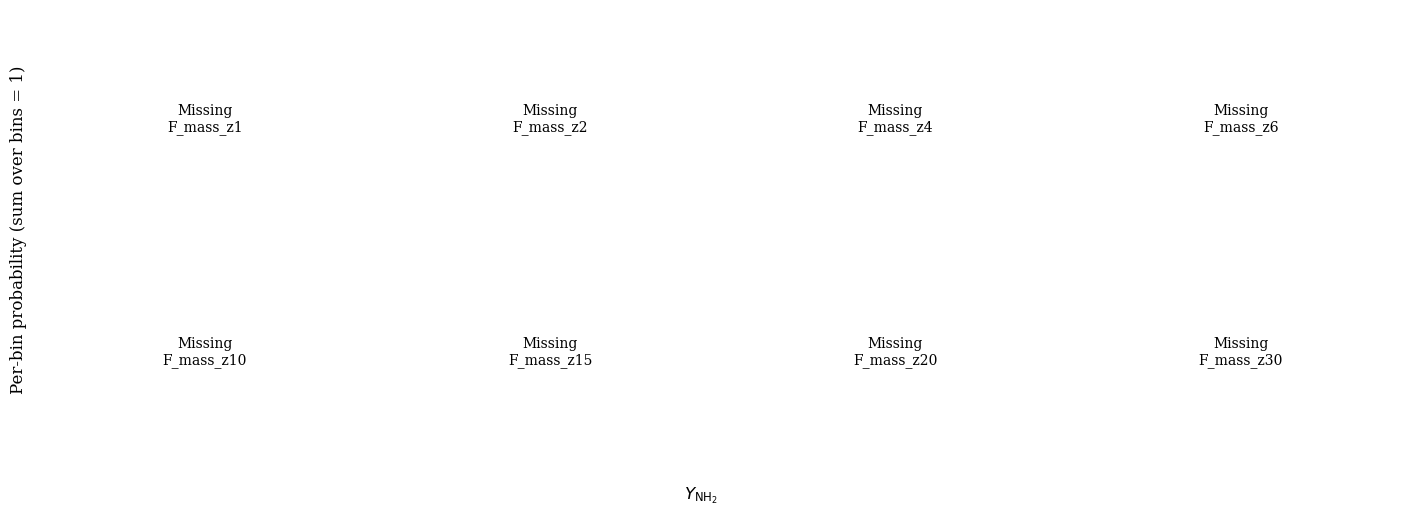

In [23]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Settings ----------
mechanism   = "KAUST_32s243r"
family      = "F"                      # "D", "E", or "F"
z_values    = [1, 2, 4, 6, 10, 15, 20, 30]
sections    = [f"{family}_mass_z{z}" for z in z_values]

# OH window to select samples from (replaces mixture-fraction window)
oh_window = (0.0, 0.002)              # <-- set your OH range here
bins      = 100                        # number of Y_NH2 bins (shared per subplot)

# Fixed Y_NH2 range for plotting the PMF
y_fixed_range = (0.0, 0.002)

# Scatter paths (everything is computed from scatter data)
scatter_base_dir   = "cases/NH3_KAUST_DEF_1bar/exp_data/single_point_csv_export"
scatter_recon_root = f"cases/NH3_KAUST_DEF_1bar/exp_data/single_shot_Exp_QSSA/{mechanism}"

# ---------- Helpers ----------
def find_col(df, keys):
    for k in keys:
        if k in df.columns:
            return k
    raise KeyError(f"None of {keys} found in {list(df.columns)}")

def compute_pmf(values, bins=80, yrange=None):
    """
    Per-bin probability (PMF-style): counts / total so that sum(pmf) = 1.
    Returns (centers, pmf, edges).
    """
    v = np.asarray(values)
    v = v[np.isfinite(v)]
    if v.size == 0:
        return np.array([]), np.array([]), np.array([])

    # Range for the histogram
    if yrange is None:
        vmin, vmax = np.nanmin(v), np.nanmax(v)
    else:
        vmin, vmax = yrange

    if not np.isfinite(vmin) or not np.isfinite(vmax):
        return np.array([]), np.array([]), np.array([])

    if vmax <= vmin:
        eps = max(1e-12, abs(vmin) * 1e-6)
        vmin, vmax = vmin - eps, vmax + eps

    counts, edges = np.histogram(v, bins=bins, range=(vmin, vmax))
    total = counts.sum()
    if total == 0:
        return np.array([]), np.array([]), edges

    pmf = counts / total               # sum over bins = 1
    centers = 0.5 * (edges[:-1] + edges[1:])
    return centers, pmf, edges

# ---------- Plot layout ----------
ncols = 4
nrows = math.ceil(len(sections) / ncols)

plt.rcParams.update({
    "font.family": "serif",
    "axes.labelsize": 11,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
})

fig, axes = plt.subplots(nrows, ncols, figsize=(3.6*ncols, 2.8*nrows), sharex=False, sharey=True)
if nrows == 1 and ncols == 1:
    axes = np.array([[axes]])
elif nrows == 1:
    axes = axes[np.newaxis, :]
elif ncols == 1:
    axes = axes[:, np.newaxis]

for i, sec in enumerate(sections):
    r, c = divmod(i, ncols)
    ax = axes[r, c]

    # Files
    base_file  = os.path.join(scatter_base_dir,  f"{sec}.csv")
    recon_file = os.path.join(scatter_recon_root, sec, "predicted_X.csv")

    if not (os.path.exists(base_file) and os.path.exists(recon_file)):
        ax.text(0.5, 0.5, f"Missing\n{sec}", ha="center", va="center", fontsize=10)
        ax.set_axis_off()
        continue

    # Load scatters
    df_b = pd.read_csv(base_file)
    df_r = pd.read_csv(recon_file)

    # Column names
    col_oh_b = find_col(df_b, ["Y_OH", "OH"])
    col_oh_r = find_col(df_r, ["Y_OH", "OH"])
    col_y_b  = find_col(df_b, ["Y_NH2", "NH2"])
    col_y_r  = find_col(df_r, ["Y_NH2", "NH2"])

    # Filter by OH window
    ohmin, ohmax = oh_window
    mask_b = np.isfinite(df_b[col_y_b]) & df_b[col_oh_b].between(ohmin, ohmax)
    mask_r = np.isfinite(df_r[col_y_r]) & df_r[col_oh_r].between(ohmin, ohmax)

    yb = df_b.loc[mask_b, col_y_b].to_numpy()
    yr = df_r.loc[mask_r, col_y_r].to_numpy()

    if yb.size == 0 and yr.size == 0:
        ax.text(0.5, 0.5, f"No data with OH∈[{ohmin:.4f},{ohmax:.4f}]\n{sec}", ha="center", va="center", fontsize=10)
        ax.set_axis_off()
        continue

    # PMF in a fixed Y_NH2 range for direct comparison
    yrange = y_fixed_range
    xc_b, pmf_b, _ = compute_pmf(yb, bins=bins, yrange=yrange) if yb.size else (np.array([]), np.array([]), np.array([]))
    xc_r, pmf_r, _ = compute_pmf(yr, bins=bins, yrange=yrange) if yr.size else (np.array([]), np.array([]), np.array([]))

    # Plot
    if xc_b.size:
        ax.plot(xc_b, pmf_b, '-',  lw=1.5, color='tab:blue', label='Exp (per-bin prob.)')
    if xc_r.size:
        ax.plot(xc_r, pmf_r, '--', lw=1.5, color='tab:red',  label='Recon (per-bin prob.)')

    ax.set_title(f"{sec}  (OH∈[{ohmin:.4f},{ohmax:.4f}])")
    ax.set_xlim(y_fixed_range)
    ax.set_ylim(bottom=0)
    ax.grid(True, alpha=0.3)

# Hide unused axes
total_cells = nrows * ncols
for idx in range(len(sections), total_cells):
    r, c = divmod(idx, ncols)
    axes[r, c].set_axis_off()

# Global labels
fig.text(0.5, 0.02, r"$Y_{\mathrm{NH_2}}$", ha="center", fontsize=12)
fig.text(0.02, 0.5, "Per-bin probability (sum over bins = 1)", va="center", rotation="vertical", fontsize=12)

# One legend at top
for row in range(nrows):
    for col in range(ncols):
        handles, labels = axes[row, col].get_legend_handles_labels()
        if handles:
            fig.legend(handles, labels, loc="upper center", ncol=4, frameon=False)
            break
    else:
        continue
    break

plt.tight_layout(rect=[0.03, 0.06, 1, 0.92])
plt.show()